In [ ]:
# SETUP AND IMPORTS
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
import sys

# --- PyTorch and Sklearn Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.metrics import average_precision_score

# --- TensorFlow for Data Loading ONLY ---
import tensorflow as tf

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define data directory 
DATA_DIR = Path("../../data/raw/ndws_western_dataset")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📂 Directory exists: {DATA_DIR.exists()}")

# Import necessary functions from other notebooks/modules
sys.path.append('../../src')

# --- CORRECTED TFRecord PARSING FUNCTION ---
def parse_tfrecord_flexible(example):
    """
    Parse TFRecord with the CORRECT feature description.
    Instead of assuming string, we now correctly specify a 64x64 float tensor.
    """
    feature_description = {}
    
    expected_features = [
        'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
        'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
        'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
        'fuel1', 'fuel2', 'fuel3', 'viirs_PrevFireMask', 'viirs_FireMask'
    ]
    
    # CRITICAL FIX: We now tell TensorFlow to expect a 64x64 array of floats.
    for feat in expected_features:
        feature_description[feat] = tf.io.FixedLenFeature([64, 64], tf.float32)
    
    parsed_features = tf.io.parse_single_example(example, feature_description)
    return parsed_features

# NOTE: The decode_feature function is no longer needed and has been removed.

print("\n✅ Setup complete - data loading functions are now corrected!")

📁 Data directory: ..\data\raw\ndws_western_dataset
📂 Directory exists: True

✅ Setup complete - data loading functions are now corrected!


In [2]:
# VISUALIZATION FUNCTIONS (PYTORCH VERSION)
def visualize_fire_predictions_pytorch(model, X_test, y_test, num_samples=4):
    """Visualize fire prediction results from a PyTorch model"""
    if len(X_test) == 0:
        print("❌ No test samples available for visualization")
        return

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    X_test_subset = X_test[:num_samples]
    y_test_subset = y_test[:num_samples]
    
    with torch.no_grad():
        # Transpose from (N, H, W, C) to (N, C, H, W) for PyTorch
        X_test_tensor = torch.from_numpy(np.transpose(X_test_subset, (0, 3, 1, 2))).float().to(device)
        predictions_tensor = model(X_test_tensor)
        # Transpose back to (N, H, W, C) for visualization with Matplotlib
        predictions = np.transpose(predictions_tensor.cpu().numpy(), (0, 2, 3, 1))

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        input_fire = X_test_subset[i, :, :, 0]
        true_fire = y_test_subset[i, :, :, 0]
        pred_fire = predictions[i, :, :, 0]

        axes[i, 0].imshow(input_fire, cmap='Reds', vmin=0, vmax=1)
        axes[i, 0].set_title(f'Sample {i+1}: Input Fire (t)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(true_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 1].set_title(f'True Fire (t+1)')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(pred_fire, cmap='Reds', vmin=0, vmax=1)
        # --- CORRECTED LABEL ---
        axes[i, 2].set_title(f'Predicted Fire (t+1)')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print(f"\n📊 PREDICTION STATISTICS:")
    print(f"🔥 True fire pixels in displayed samples: {np.sum(y_test_subset > 0.1)}")
    print(f"🎯 Predicted fire pixels (threshold > 0.5): {np.sum(predictions > 0.5)}")
    print(f"📈 Average prediction confidence: {np.mean(predictions):.4f}")

print("✅ PyTorch visualization function defined with corrected t+1 labels!")

✅ PyTorch visualization function defined with corrected t+1 labels!


# 🔥 SPATIAL FIRE SPREAD PREDICTION WITH U-NET ARCHITECTURE

**CRITICAL FIX**: This section implements proper spatial fire spread prediction using:
- ✅ **Raw spatial features** (64x64 grids) - NOT statistical summaries
- ✅ **All 23 environmental features** as spatial inputs
- ✅ **U-Net architecture** for pixel-level fire spread prediction
- ✅ **Temporal prediction**: PrevFireMask(t) → FireMask(t+1)
- ✅ **Research-based approach** following wildfire prediction literature

**Key Point**: The engineered features above are for EDA/visualization only. All prediction uses RAW SPATIAL DATA.

In [3]:
# --- NEW DATA PROCESSOR FOR SINGLE-DAY (t -> t+1) PREDICTION (CORRECTED) ---

class SingleDayFireDataProcessor:
    """
    Processes raw TFRecord data for NEXT-DAY fire spread prediction
    using ONLY the current day's data (no time-series context).
    (Corrected to ensure fire mask is the first channel).
    """
    def __init__(self, data_dir=DATA_DIR):
        self.data_dir = data_dir
        # Separate the fire feature from the environmental features
        self.fire_feature = 'viirs_PrevFireMask'
        self.environmental_features = [
            'elevation', 'NDVI', 'erc', 'pr', 'pdsi', 'population',
            'impervious', 'water', 'tmp_day', 'tmp_75', 'wind_avg', 'wind_75',
            'wdir_wind', 'wdir_gust', 'gust_med', 'avg_sph', 'bi', 'chili',
            'fuel1', 'fuel2', 'fuel3'
        ]
        self.target_feature = 'viirs_FireMask'

    def load_raw_spatial_data(self, max_sequences=None):
        """
        Load and create single-day sequences.
        Input X: All features from day 't', with fire mask as channel 0.
        Target Y: The FireMask from day 't+1'.
        """
        print("🔥 Loading RAW SPATIAL DATA for SINGLE-DAY (t -> t+1) prediction...")
        
        tfrecord_files = list(self.data_dir.glob("*.tfrecord"))
        if not tfrecord_files:
            print("❌ No TFRecord files found!")
            return None, None
        print(f"📁 Found {len(tfrecord_files)} TFRecord files")

        all_samples_flat = []
        for file_path in tfrecord_files:
            dataset = tf.data.TFRecordDataset(str(file_path))
            for raw_record in dataset:
                try:
                    parsed_sample = parse_tfrecord_flexible(raw_record)
                    sample_data = {name: tensor.numpy() for name, tensor in parsed_sample.items()}
                    if self.fire_feature in sample_data and self.target_feature in sample_data:
                        all_samples_flat.append(sample_data)
                except Exception as e:
                    print(f"❗️ FAILED TO PROCESS A RECORD in {file_path.name}. Error: {e}")
                    break
            else: continue
            break
        
        print(f"  ...Loaded {len(all_samples_flat)} total individual samples.")

        if not all_samples_flat:
             print("❌ No valid samples were loaded.")
             return None, None

        # --- CORRECTED SINGLE-DAY LOGIC ---
        spatial_inputs, spatial_targets = [], []
        
        for i in range(len(all_samples_flat) - 1):
            if max_sequences and len(spatial_inputs) >= max_sequences:
                break

            current_day_sample = all_samples_flat[i]
            next_day_sample = all_samples_flat[i + 1]

            # --- Assemble the Input Tensor (X) with corrected order ---
            input_features = []
            
            # 1. Add the fire mask FIRST to ensure it is channel 0
            if self.fire_feature in current_day_sample:
                input_features.append(current_day_sample[self.fire_feature].reshape(64, 64, 1))

            # 2. Add all other environmental features
            for feature_name in self.environmental_features:
                if feature_name in current_day_sample:
                    input_features.append(current_day_sample[feature_name].reshape(64, 64, 1))
            
            # --- Assemble the Target Tensor (y) ---
            target_mask = next_day_sample[self.target_feature].reshape(64, 64, 1)

            # Check if all features were found (1 fire + 21 env)
            if len(input_features) == len(self.environmental_features) + 1:
                spatial_inputs.append(np.concatenate(input_features, axis=2))
                spatial_targets.append(target_mask)

        if not spatial_inputs:
            print("❌ Could not create any sequences with the single-day logic!")
            return None, None
            
        X_spatial = np.array(spatial_inputs, dtype=np.float32)
        y_spatial = np.array(spatial_targets, dtype=np.float32)

        print(f"\n✅ SINGLE-DAY DATA LOADING COMPLETE")
        print(f"📊 Spatial Input Shape: {X_spatial.shape}")
        print(f"📊 Spatial Target Shape: {y_spatial.shape}")
        return X_spatial, y_spatial

In [4]:
# PYTORCH U-NET ARCHITECTURE, LOSS FUNCTION, AND NEW K-FOLD CROSS-VALIDATION TRAINING FUNCTION

# --- 1. LOSS FUNCTION: BCE + Dice ---
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight = weight

    def forward(self, inputs, targets, smooth=1e-6):
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        
        bce_loss = nn.BCELoss()(inputs_flat, targets_flat)
        
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + smooth) / (inputs_flat.sum() + targets_flat.sum() + smooth)
        dice_loss = 1 - dice_score
        
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

# --- 2. U-NET MODEL DEFINITION IN PYTORCH ---
class FireUNetPyTorch(nn.Module):
    def __init__(self, in_channels, out_channels, filters_base=32):
        super(FireUNetPyTorch, self).__init__()
        def _conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True))
        
        self.enc1 = _conv_block(in_channels, filters_base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = _conv_block(filters_base, filters_base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = _conv_block(filters_base*2, filters_base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = _conv_block(filters_base*4, filters_base*8)
        self.pool4 = nn.MaxPool2d(2)
        self.bottleneck = _conv_block(filters_base*8, filters_base*16)
        self.upconv4 = nn.ConvTranspose2d(filters_base*16, filters_base*8, 2, stride=2)
        self.dec4 = _conv_block(filters_base*16, filters_base*8)
        self.upconv3 = nn.ConvTranspose2d(filters_base*8, filters_base*4, 2, stride=2)
        self.dec3 = _conv_block(filters_base*8, filters_base*4)
        self.upconv2 = nn.ConvTranspose2d(filters_base*4, filters_base*2, 2, stride=2)
        self.dec2 = _conv_block(filters_base*4, filters_base*2)
        self.upconv1 = nn.ConvTranspose2d(filters_base*2, filters_base, 2, stride=2)
        self.dec1 = _conv_block(filters_base*2, filters_base)
        self.out_conv = nn.Conv2d(filters_base, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b = self.bottleneck(self.pool4(e4))
        d4 = self.dec4(torch.cat([self.upconv4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.upconv3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.upconv2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        return torch.sigmoid(self.out_conv(d1))

# --- 3. NEW TRAINING FUNCTION WITH K-FOLD AND AVERAGE PRECISION ---
def train_fire_unet_cv_pytorch(X_spatial, y_spatial, n_splits=5, epochs=20, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 INITIATING U-NET TRAINING ON {device} WITH {n_splits}-FOLD CV")
    print(f"🎯 Main Metric: Average Precision (AP)")
    print("=" * 60)
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_ap_scores = []
    last_model = None

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_spatial)):
        print(f"\n========== FOLD {fold + 1}/{n_splits} ==========")
        # (Data preparation code is the same as before)
        X_train, X_val = X_spatial[train_idx], X_spatial[val_idx]
        y_train, y_val = y_spatial[train_idx], y_spatial[val_idx]

        X_train_t = np.transpose(X_train, (0, 3, 1, 2))
        X_val_t = np.transpose(X_val, (0, 3, 1, 2))
        y_train_t = (np.transpose(y_train, (0, 3, 1, 2)) > 0.1).astype(np.float32)
        y_val_t = (np.transpose(y_val, (0, 3, 1, 2)) > 0.1).astype(np.float32)
        
        channel_means = np.mean(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds = np.std(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds[channel_stds == 0] = 1

        X_train_norm = (X_train_t - channel_means) / channel_stds
        X_val_norm = (X_val_t - channel_means) / channel_stds
        
        train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_norm), torch.from_numpy(y_train_t)), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val_norm), torch.from_numpy(y_val_t)), batch_size=batch_size, shuffle=False)
        
        model = FireUNetPyTorch(in_channels=X_train_norm.shape[1], out_channels=1).to(device)
        criterion = BCEDiceLoss(weight=0.5)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        # --- UPDATED TRAINING LOOP WITH EPOCH PROGRESS ---
        print(f"🔥 STARTING TRAINING for {epochs} epochs...")
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs.to(device))
                loss = criterion(outputs, labels.to(device))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            # Print average loss for the epoch
            epoch_loss = running_loss / len(train_loader)
            print(f"  Epoch {epoch + 1}/{epochs} - Training Loss: {epoch_loss:.4f}")
        
        # (Evaluation part is the same as before)
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device))
                all_preds.append(outputs.cpu().numpy().flatten())
                all_labels.append(labels.numpy().flatten())
        
        ap_score = average_precision_score(np.concatenate(all_labels), np.concatenate(all_preds))
        fold_ap_scores.append(ap_score)
        print(f"✅ Fold {fold + 1} Validation - AP: {ap_score:.4f}")
        last_model = model

    # --- FINAL SUMMARY AND MODEL SAVING ---
    print("\n\n📊 CROSS-VALIDATION SUMMARY")
    print("=" * 60)
    print(f"  - Mean AP ± Std Dev: {np.mean(fold_ap_scores):.4f} ± {np.std(fold_ap_scores):.4f}")
    
    # --- ADDED: SAVE THE FINAL MODEL ---
    if last_model:
        model_save_path = "final_fire_unet.pth"
        torch.save(last_model.state_dict(), model_save_path)
        print(f"\n💾 Final model from the last fold saved to '{model_save_path}'")
    
    return last_model, fold_ap_scores

🔥 Loading RAW SPATIAL DATA for SINGLE-DAY (t -> t+1) prediction...
📁 Found 54 TFRecord files
  ...Loaded 20097 total individual samples.

✅ SINGLE-DAY DATA LOADING COMPLETE
📊 Spatial Input Shape: (500, 64, 64, 22)
📊 Spatial Target Shape: (500, 64, 64, 1)

--- Training SINGLE-DAY Model ---
🚀 INITIATING U-NET TRAINING ON cpu WITH 3-FOLD CV
🎯 Main Metric: Average Precision (AP)

========== FOLD 1/3 ==========
🔥 STARTING TRAINING for 15 epochs...
  Epoch 1/15 - Training Loss: 0.6680
  Epoch 2/15 - Training Loss: 0.5432
  Epoch 3/15 - Training Loss: 0.5197
  Epoch 4/15 - Training Loss: 0.5059
  Epoch 5/15 - Training Loss: 0.4975
  Epoch 6/15 - Training Loss: 0.4895
  Epoch 7/15 - Training Loss: 0.4833
  Epoch 8/15 - Training Loss: 0.4762
  Epoch 9/15 - Training Loss: 0.4707
  Epoch 10/15 - Training Loss: 0.4697
  Epoch 11/15 - Training Loss: 0.4605
  Epoch 12/15 - Training Loss: 0.4641
  Epoch 13/15 - Training Loss: 0.4609
  Epoch 14/15 - Training Loss: 0.4579
  Epoch 15/15 - Training Loss:

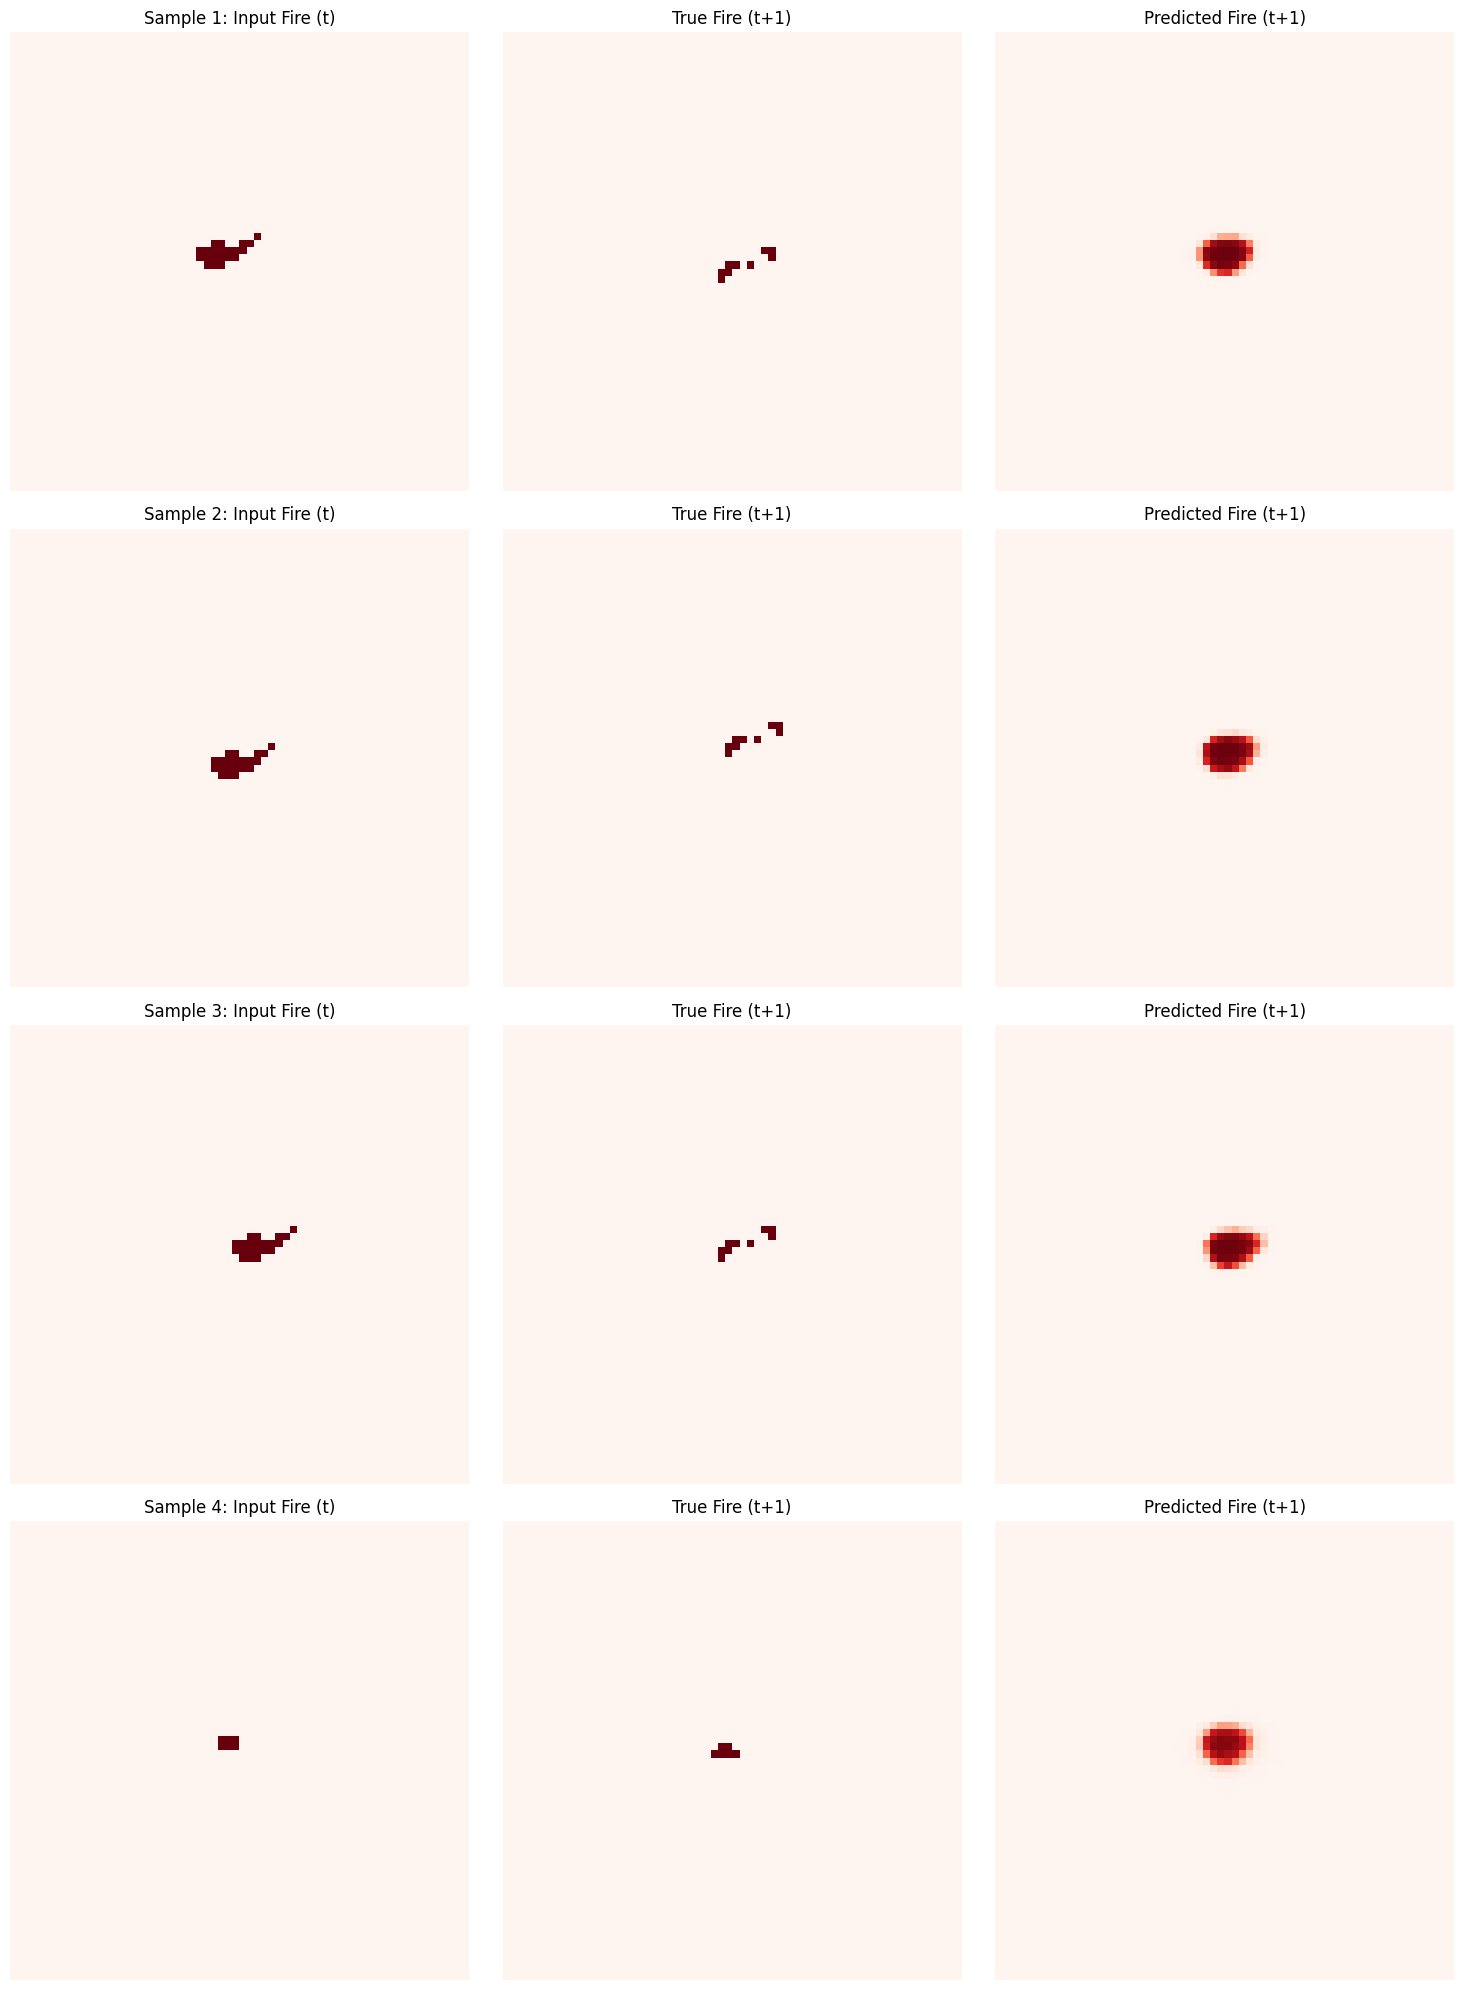


📊 PREDICTION STATISTICS:
🔥 True fire pixels in displayed samples: 33
🎯 Predicted fire pixels (threshold > 0.5): 113
📈 Average prediction confidence: 0.0070


In [5]:
# --- EXECUTION FOR SINGLE-DAY (t -> t+1) PREDICTION FOR COMPARISON (CORRECTED) ---

# 1. Load the data using the NEW single-day processor
single_day_processor = SingleDayFireDataProcessor()
X_spatial_single, y_spatial_single = single_day_processor.load_raw_spatial_data(max_sequences=500)

# 2. Train the PyTorch U-Net model with the single-day data
final_model_single_day = None 
cv_results_single = []

if X_spatial_single is not None:
    print("\n--- Training SINGLE-DAY Model ---")
    
    # We reuse the same training function, it's flexible enough!
    final_model_single_day, cv_results_single = train_fire_unet_cv_pytorch(
        X_spatial_single, y_spatial_single,
        n_splits=3,
        epochs=15, 
        batch_size=4
    )
    
    # Save the model with a new name to distinguish it
    if final_model_single_day:
        torch.save(final_model_single_day.state_dict(), "single_day_fire_unet.pth")
        print("\n💾 Single-day model saved to 'single_day_fire_unet.pth'")
        print("\n🎉 SINGLE-DAY U-NET TRAINING COMPLETED!")
    else:
        print(f"❌ Single-day U-Net training failed!")
else:
    print(f"❌ Cannot train single-day U-Net - no data loaded!")
    
# 3. Visualize results from the single-day model
if final_model_single_day is not None:
    print(f"\n🎨 GENERATING VISUALIZATIONS for SINGLE-DAY model...")
    
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    # --- CORRECTED LOGIC FOR SELECTING DATA ---
    # Use clearer variable names and select all training indices for the last fold
    train_indices_last_fold, val_indices_last_fold = list(kfold.split(X_spatial_single))[-1]
    
    X_train_last_fold = X_spatial_single[train_indices_last_fold] # Fixed: Use the full index array
    X_test_viz = X_spatial_single[val_indices_last_fold]
    y_test_viz = y_spatial_single[val_indices_last_fold]
    
    num_viz_samples = min(4, len(X_test_viz))
    if num_viz_samples > 0:
        # Normalization logic is the same, but now receives the correct 4D array
        X_train_t = np.transpose(X_train_last_fold, (0, 3, 1, 2))
        channel_means = np.mean(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds = np.std(X_train_t, axis=(0, 2, 3), keepdims=True)
        channel_stds[channel_stds == 0] = 1

        X_test_viz_t = np.transpose(X_test_viz[:num_viz_samples], (0, 3, 1, 2))
        X_test_norm_t = (X_test_viz_t - channel_means) / channel_stds
        X_test_norm = np.transpose(X_test_norm_t, (0, 2, 3, 1))

        y_test_binary = (y_test_viz[:num_viz_samples] > 0.1).astype(np.float32)
        
        # We reuse the same visualization function
        visualize_fire_predictions_pytorch(
            final_model_single_day, X_test_norm, y_test_binary, num_samples=num_viz_samples
        )
    else:
        print("Not enough validation samples to visualize.")
else:
    print(f"\n⚠️ Single-day model not available for evaluation.")